#Lucas Kanade Method

##Importing Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [ ]:
def pad(img,k):
  img=np.insert(img,img.shape[0],img[img.shape[0]-1,:],axis=0)
  img=np.insert(img,img.shape[1],img[:,img.shape[1]-1],axis=1)
  for i in range(k//2):
      img=np.insert(img,img.shape[0],img[img.shape[0]-1,:],axis=0)
      img=np.insert(img,img.shape[1],img[:,img.shape[1]-1],axis=1)
      img=np.insert(img,0,img[0,:],axis=0)
      img=np.insert(img,0,img[:,0],axis=1)
  return img

In [ ]:
def LK(str1,str2,str3):
  gt=np.load(str3)
  img_1=cv2.cvtColor(cv2.imread(str1),cv2.COLOR_BGR2GRAY).astype(np.float32)
  img_2=cv2.cvtColor(cv2.imread(str2),cv2.COLOR_BGR2GRAY).astype(np.float32)
  plt.subplot(2, 3, 1)
  plt.imshow(img_1, cmap = 'gray')
  plt.subplot(2, 3, 2)
  plt.imshow(img_2, cmap = 'gray')
  plt.subplot(2, 3, 3)
  plt.imshow(gt, cmap = 'gray')
  w=3
  for kernel in [3,5,15]:
      img1=pad(img_1,kernel)
      img2=pad(img_2,kernel)
      r,c=img1.shape
      I_x=np.zeros((r-1,c-1))
      I_y=np.zeros((r-1,c-1))
      I_t=np.zeros((r-1,c-1))
      for i in range(r-1):
        for j in range(c-1):
          I_x[i,j]=0.25*(img1[i+1,j]+img2[i+1,j]+img1[i+1,j+1]+img2[i+1,j+1]-(img1[i,j]+img2[i,j]+img1[i,j+1]+img2[i,j+1]))
          I_y[i,j]=0.25*(img1[i,j+1]+img2[i,j+1]+img1[i+1,j+1]+img2[i+1,j+1]-(img1[i,j]+img2[i,j]+img1[i+1,j]+img2[i+1,j]))
          I_t[i,j]=0.25*(img2[i,j+1]+img2[i+1,j+1]+img2[i+1,j]+img2[i,j]-(img1[i,j+1]+img1[i+1,j+1]+img1[i+1,j]+img1[i,j]))
      optical_flow=np.zeros((r-kernel,c-kernel))
      r,c=optical_flow.shape
      for i in range(kernel//2,r+kernel//2):
        for j in range(kernel//2,c+kernel//2):
          A=np.zeros((kernel*kernel,2))
          b=np.zeros((kernel*kernel,1))
          l=0
          for m in range(i-kernel//2,i+kernel//2+1):
            for n in range(j-kernel//2,j+kernel//2+1):
              A[l][0]=I_x[m,n]
              A[l][1]=I_y[m,n]
              b[l][0]=-I_t[m,n]
              l+=1
          h=(A.T@A)
          if (np.linalg.det(h)!=0):
            u=(np.linalg.inv(h)@A.T@b)
          else :
            u=np.array([[0],[0]])
          optical_flow[i-kernel//2,j-kernel//2]=((u[1,0])**2 + (u[0,0])**2 )**0.5
      plt.subplot(2, 3, w+1)
      plt.imshow(optical_flow, cmap = 'gray')
      w+=1
      MSE =np.square(((optical_flow-gt))).mean()
      print(f' For patch size = {kernel} X {kernel}, MSE = {MSE}.')

 For patch size = 3 X 3, MSE = 71.72264556563962.
 For patch size = 5 X 5, MSE = 70.11436223973823.
 For patch size = 15 X 15, MSE = 73.42094078789727.


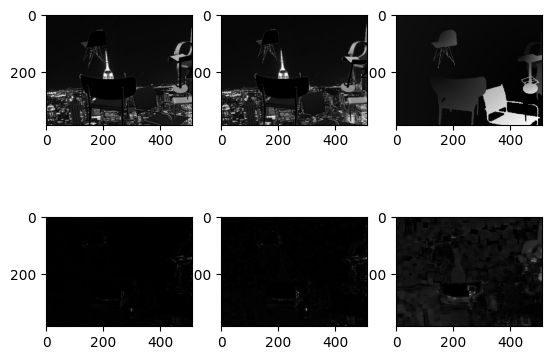

In [ ]:
LK('img1.jpg','img2.jpg','GT1.npy')

 For patch size = 3 X 3, MSE = 883.4159925318016.
 For patch size = 5 X 5, MSE = 898.2989484002615.
 For patch size = 15 X 15, MSE = 1041.00626073017.


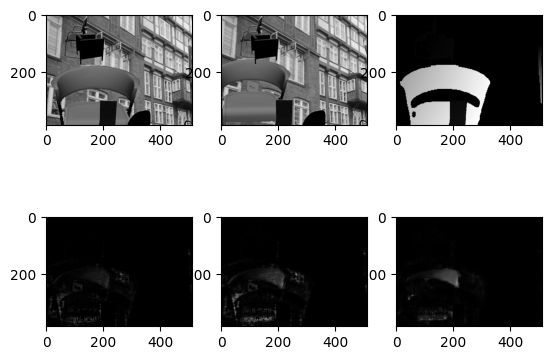

In [ ]:
LK('img1.jpg','img2.jpg','GT2.npy')

 For patch size = 3 X 3, MSE = 779.3758526620862.
 For patch size = 5 X 5, MSE = 817.8475768068301.
 For patch size = 15 X 15, MSE = 862.9456852441105.


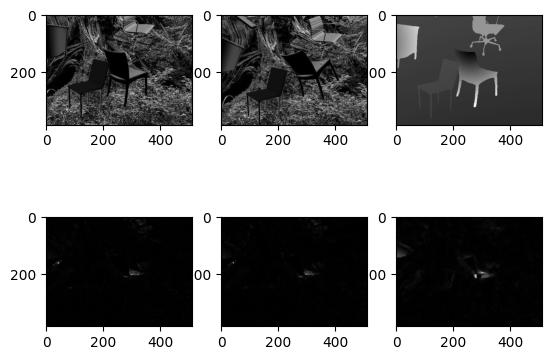

In [ ]:
LK('img1.jpg','img2.jpg','GT3.npy')

#BLOCK MATCHING

#Finding Optical Flow 1 using Exhaustive Search

In [ ]:
def pad2(img,k):
  for i in range(k):
      img=np.insert(img,img.shape[0],np.zeros((1,img.shape[1])),axis=0)
      img=np.insert(img,img.shape[1],np.zeros((img.shape[0],1)).reshape((img.shape[0],)),axis=1)
      img=np.insert(img,0,np.zeros((1,img.shape[1])),axis=0)
      img=np.insert(img,0,np.zeros((img.shape[0],1)).reshape((img.shape[0],)),axis=1)
  return img
def ex_search(b,a):
    r,c=b.shape
    l,k=a.shape
    l=l//2
    k=k//2
    r=r//2
    c=c//2
    loss=np.square(a[0:2*r+1,0:2*c+1]-b).sum()
    m,n=r,c
    f=((m-l)**2+(n-k)**2)**0.5
    for i in range(r,a.shape[0]-r):
      for j in range(c,a.shape[1]-c):
        loss1=np.square(a[i-r:i+r+1,j-c:j+c+1]-b).mean()
        if(loss1<=loss):
          loss=loss1
          if (((i-l)**2+(j-k)**2)**0.5)<f:
            m,n=i,j
            f=((m-l)**2+(n-k)**2)**0.5
    return f

In [ ]:
def EXH_search(str1,str2,str3,blocksize=5,window=8):
  pad=window+blocksize//2
  img_1=cv2.cvtColor(cv2.imread(str1),cv2.COLOR_BGR2GRAY).astype(np.float32)
  img_2=cv2.cvtColor(cv2.imread(str2),cv2.COLOR_BGR2GRAY).astype(np.float32)
  gt=np.load(str3)
  plt.subplot(1, 4, 1)
  plt.imshow(img_1, cmap = 'gray')
  plt.subplot(1, 4, 2)
  plt.imshow(img_2, cmap = 'gray')
  plt.subplot(1, 4, 3)
  plt.imshow(gt, cmap = 'gray')
  flow=np.zeros(img_1.shape)
  img1=pad2(img_1,blocksize//2)
  img2=pad2(img_2,pad)
  r,c=img1.shape
  j=3
  for i in range (blocksize//2,r-blocksize//2):
    for j in range (blocksize//2,c-blocksize//2):
      flow[i-blocksize//2,j-blocksize//2]=ex_search(img1[i-blocksize//2:i+1+blocksize//2,j-blocksize//2:j+1+blocksize//2],img2[i+window-pad:i+window+1+pad,j+window-pad:j+window+1+pad])
  plt.subplot(1, 4, 4)
  plt.imshow(flow, cmap = 'gray')
  MSE = np.square(np.subtract(flow.flatten(),gt.flatten())).mean()
  print(f' For window size , MSE = {MSE}.')
  return flow

##Finding Optical Flow of Image 1 using exhaustive Search

 For window size , MSE = 56.14923603373609.


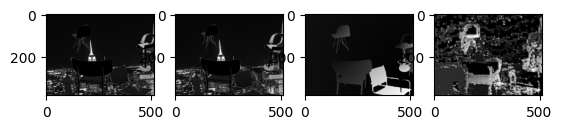

In [ ]:
flow=EXH_search('img1.jpg','img2.jpg','GT1.npy')

##Finding Optical Flow of Image 2 using exhaustive Search

 For window size , MSE = 1061.2362034168968.


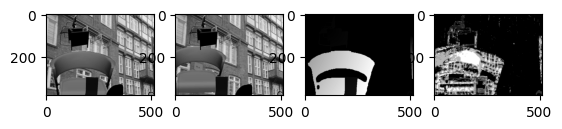

In [ ]:
flow=EXH_search('img1.jpg','img2.jpg','GT2.npy')

##Finding Optical Flow of Image 3 using exhaustive Search

 For window size , MSE = 654.3070909692527.


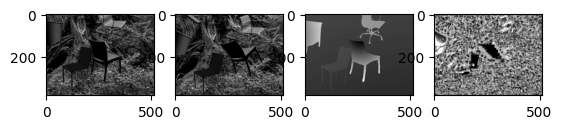

In [ ]:
flow=EXH_search('img1.jpg','img2.jpg','GT3.npy')

#Finding Optical Flow 1 using 3-Step Search

In [ ]:
def three_step(b,a,S):
    r,c=b.shape
    l,k=a.shape
    l=l//2
    k=k//2
    l1,k1=l,k
    r=r//2
    c=c//2
    loss=np.square(a[l-S-r:l-S+r+1,k-S-c:k-S+c+1]-b).sum()
    m,n=r,c
    f=((m-l1)**2+(n-k1)**2)**0.5
    while(S!=1):
      for i in [l-S,l,l+S-1]:
        for j in [k-S,k,k+S-1]:
            loss1=np.square(a[i-r:i+r+1,j-c:j+c+1]-b).mean()
            if(loss1<=loss):
              loss=loss1
              if (((i-l1)**2+(j-k1)**2)**0.5)<f:
                m,n=i,j
                f=((m-l1)**2+(n-k1)**2)**0.5
      S=S//2
      l,k=m,n
    for i in [l-S,l,l+S-1]:
      for j in [k-S,k,k+S-1]:
         loss1=np.square(a[i-r:i+r+1,j-c:j+c+1]-b).mean()
         if(loss1<=loss):
            loss=loss1
            if (((i-l1)**2+(j-k1)**2)**0.5)<f:
              m,n=i,j
              f=((m-l1)**2+(n-k1)**2)**0.5
    return ((m-l1)**2+(n-k1)**2)**0.5

In [ ]:
def TS_search(str1,str2,str3,blocksize=3):
  blocksize=3
  S=4
  pad=7+blocksize//2
  img_1=cv2.cvtColor(cv2.imread(str1),cv2.COLOR_BGR2GRAY).astype(np.float32)
  img_2=cv2.cvtColor(cv2.imread(str2),cv2.COLOR_BGR2GRAY).astype(np.float32)
  gt=np.load(str3)
  plt.subplot(1, 4, 1)
  plt.imshow(img_1, cmap = 'gray')
  plt.subplot(1, 4, 2)
  plt.imshow(img_2, cmap = 'gray')
  plt.subplot(1, 4, 3)
  plt.imshow(gt, cmap = 'gray')
  flow=np.zeros(img_1.shape)
  img1=pad2(img_1,blocksize//2)
  img2=pad2(img_2,pad)
  r,c=img1.shape
  j=3
  for i in range (blocksize//2,r-blocksize//2):
    for j in range (blocksize//2,c-blocksize//2):
      flow[i-blocksize//2,j-blocksize//2]=three_step(img1[i-blocksize//2:i+1+blocksize//2,j-blocksize//2:j+1+blocksize//2],img2[i+7-pad:i+7+1+pad,j+7-pad:j+7+1+pad],S)
  plt.subplot(1, 4, 4)
  plt.imshow(flow, cmap = 'gray')
  MSE = np.square(np.subtract(flow.flatten(),gt.flatten())).mean()
  print(f' MSE = {MSE}.')

##Finding Optical Flow of Image 1 using 3-Step Search

 MSE = 65.76100748782706.


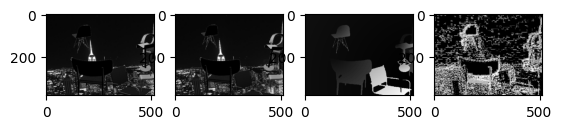

In [ ]:
TS_search('img1.jpg','img2.jpg','GT1.npy')

##Finding Optical Flow of Image 2 using 3-Step Search

 For window size , MSE = 1127.6702473796188.


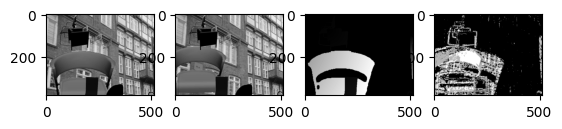

In [ ]:
TS_search('img1.jpg','img2.jpg','GT2.npy')

##Finding Optical Flow of Image 3 using 3-Step Search

 For window size , MSE = 738.430352027979.


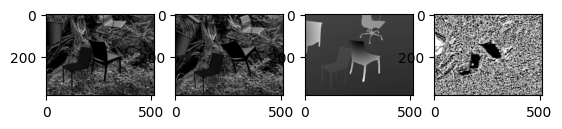

In [ ]:
TS_search('img1.jpg','img2.jpg','GT3.npy')

#Finding Optical Flow using Diamond Search

In [ ]:
def ins(img, k, l) :
  try:
      return img[k][l]
  except IndexError:
      return 0
def fbmp1(img1,img2,bsize,indx1,indy1,indx2,indy2) :
  optcost = 1e30
  kmin = 0
  lmin = 0
  bsize=16
  for k in [-2,-1,0,1,2] :
    ## obtaining the indices for large diamond search pattern
    if k == -2 or k==2 : listl = [0]
    elif k == -1 or k==1 : listl = [-1,1]
    else : listl = [-2,0,2]
    for l in listl :
      ## calculating mean absolute difference
      sum = 0
      for i in range(bsize) :
        for j in range(bsize) :
          sum +=(abs(ins(img2, indx1+i, indy1+j)-ins(img1, indx2+k+i, indy2+l+j)))
      sum /= (bsize**2)
      if sum<optcost :
        optcost = sum
        kmin = k
        lmin = l
  ## returning the best matching position
  return kmin,lmin

In [ ]:
def fbmp2(img1,img2,bsize,indx1,indy1,indx2,indy2) :
  # bsize is block-size
  # (indx1, indy1) are the starting indices of the reference block.
  optcost = 1e30
  kmin = 0
  lmin = 0
  bsize=16
  for k in [-1,0,1] :
    ## obtaining the indices for large diamond search pattern
    if k == -1 or k==1 : listl = [0]
    else : listl = [-1,0,1]
    for l in listl :
      ## calculating mean absolute difference
      sum = 0
      for i in range(bsize) :
        for j in range(bsize) :
          sum +=(abs(ins(img2, indx1+i, indy1+j)-ins(img1, indx2+k+i, indy2+l+j)))
      sum /= (bsize**2)
      if sum<optcost :
        optcost = sum
        kmin = k
        lmin = l
  ## returning the best matching position
  return kmin,lmin
def flow3(img1,img2,indx,indy,ind) :
  ## storing the original indices and initializing required variables
      origx = indx
      origy = indy
      optval = 0
      kmin = 0
      lmin = 0
      kt = 0
      lt = -1
      bsize=16
      ## performing large diamond search pattern as long as the best block is not at the center
      while (kt**2+lt**2)!=0 :
        kt, lt = fbmp1(img1,img2,bsize,origx,origy,indx,indy)
        indx = indx + kt
        indy = indy + lt
        kmin += kt
        lmin += lt
      ## performing small diamond search pattern
      kt, lt = fbmp2(img1,img2,bsize,origx,origy,indx,indy)
      kmin += kt
      lmin += lt
      optval = math.sqrt(kmin**2+lmin**2)
      return optval

In [ ]:
def diamond_search(str1,str2,str3):
  gt= np.load(str3)
  img1 = cv2.cvtColor(cv2.imread(str1), cv2.COLOR_BGR2GRAY).astype('int64')
  img2 = cv2.cvtColor(cv2.imread(str2), cv2.COLOR_BGR2GRAY).astype('int64')

  bsize = 16
  field = np.zeros(img1.shape)

  ## calculating the optical flow using diamond search at every pixel
  p = math.ceil(img1.shape[0]/bsize)
  q = math.ceil(img1.shape[1]/bsize)
  for i in range(p) :
    for j in range(q) :
      indx = bsize*i
      indy = bsize*j
      flow = flow3(img1,img2,indx,indy,1)
      for m in range(bsize) :
        for n in range(bsize) :
          field[indx+m][indy+n] = flow

  MSE = np.square(field-gt).mean()       # calculating MSE

  ## printing the images, the ground truth and the optical flow
  plt.subplot(1, 4, 1)
  plt.imshow(img1, cmap='gray')
  plt.subplot(1, 4, 2)
  plt.imshow(img2, cmap='gray')
  plt.subplot(1, 4, 3)
  plt.imshow(gt, cmap='gray')
  plt.subplot(1, 4, 4)
  plt.imshow(field, cmap='gray')
  print("MSE obtained is:", MSE)

##For image 1

MSE obtained is: 96.43568533483723


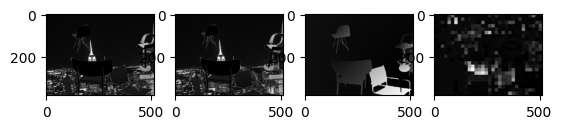

In [ ]:
diamond_search('img1.jpg','img2.jpg','GT1.npy')

##For image 2

MSE obtained is: 711.0117536739969


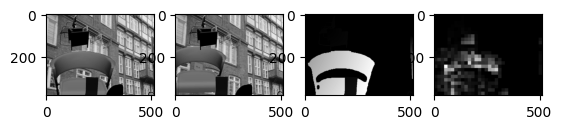

In [ ]:
diamond_search('img1.jpg','img2.jpg','GT2.npy')

##For Image 3


The MSE obtained for dataset D1 is: 606.2620948405958


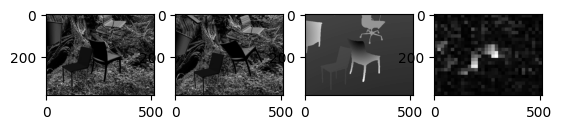

In [ ]:
diamond_search('img1.jpg','img2.jpg','GT3.npy')